#  Gene Sets and Expression for Primary Site Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to  prune the number of genes/features.

In [12]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(42)

# See https://github.com/h5py/h5py/issues/712
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" 

## Load TCGA+TARGET+GTEX

Load expression and create a one hot output vector

In [3]:
X = pd.read_hdf("data/tcga_target_gtex.h5", "expression")
X.head()

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.966042,-9.965816,-9.965880,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.1140,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,5.326995,-9.9658
GTEX-1117F-0426-SM-5EGHI,-9.966042,-9.965816,-9.965880,1.1512,-1.2828,-6.5064,6.0777,-2.3147,0.5568,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,3.037565,-9.9658
GTEX-1117F-0526-SM-5EGHJ,-9.966042,-9.965816,-9.965880,5.2411,0.8488,-6.5064,10.0319,0.1257,-1.1172,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,4.302417,-9.9658
GTEX-1117F-0626-SM-5N9CS,-9.966042,-9.965816,-9.965880,5.4758,2.6325,-9.9658,9.7572,1.7702,-1.8836,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,4.248770,-9.9658
GTEX-1117F-0726-SM-5GIEN,-9.966042,-9.965816,-0.833902,4.5534,1.3051,-9.9658,7.7931,-0.0725,-2.2447,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,3.145838,-9.9658


In [4]:
Y = pd.read_hdf("data/tcga_target_gtex.h5", "labels")
Y.head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0426-SM-5EGHI,Muscle - Skeletal,Muscle - Skeletal,Muscle,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0526-SM-5EGHJ,Artery - Tibial,Artery - Tibial,Blood Vessel,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0626-SM-5N9CS,Artery - Coronary,Artery - Coronary,Blood Vessel,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0726-SM-5GIEN,Heart - Atrial Appendage,Heart - Atrial Appendage,Heart,Normal Tissue,Female,GTEX,Normal


## Ingest Pathways

Load gene sets downloaded from msigdb filter out data to only include gene's present in the union of all the pathways

In [5]:
# Load gene sets from downloaded MSigDB gmt file
# KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = {line.strip().split("\t")[0]: line.strip().split("\t")[2:]
                 for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop  genes not in X - sort so order is the same as X_pruned.columns
gene_sets = {name:
             sorted([gene for gene in genes if gene in X.columns.values])
             for name, genes in gene_sets.items()}

# Find union of all gene's in all gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(
    *[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns)
                          - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19126, 5172)


## Wrangle Labels, Train and Test Sets

Add one hot labels for primary site and stratify into test and train on primary site

In [6]:
from sklearn.preprocessing import LabelEncoder
primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(
    primary_site_encoder.fit_transform(Y["primary_site"]), index=Y.index)

Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,primary_site_value
count,19126,19126,19126,19126,19126,19126,19126,19126.000000
unique,93,93,46,16,3,3,2,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN
freq,1212,1212,1846,9185,10453,10534,10530,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.651992
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.419634
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.000000


In [7]:
# Create one hots for training
from keras.utils import np_utils
Y_primary_site_one_hot = np_utils.to_categorical(Y["primary_site_value"])
print(Y_primary_site_one_hot[0:20000:5000])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
# Split into stratified training and test sets based primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["primary_site_value"]):
    X_train = X_pruned.values[train_index]
    X_test = X_pruned.values[test_index]
    y_train = Y_primary_site_one_hot[train_index]
    y_test = Y_primary_site_one_hot[test_index]
    primary_site_train = Y["primary_site_value"].values[train_index]
    primary_site_test = Y["primary_site_value"].values[test_index]

print(X_train.shape, X_test.shape)

(15300, 5172) (3826, 5172)


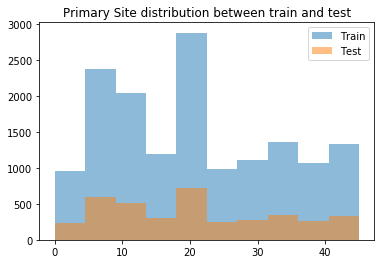

In [13]:
# Lets see how big each class is based on primary site
plt.hist(primary_site_train, alpha=0.5, label='Train')
plt.hist(primary_site_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Primary Site distribution between train and test")
plt.show()

## Primary Site Classification
Classification of primary site with union of genes from all gene sets as input

In [103]:
%%time
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(16, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),

    Dense(y_train.shape[1], activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=10, batch_size=128, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5172)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5172)              20688     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                165536    
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 46)                782       
Total para

## Evaluate Model
Use the trained model to predict all the test samples and generate a confusion matrix

In [104]:
%%time
predictions = model.predict(X_test)

labels = primary_site_encoder.classes_.tolist()

CPU times: user 4.39 s, sys: 2.6 s, total: 7 s
Wall time: 404 ms


In [105]:
# Let's eye ball the top three predictions against ground truth
[(labels[primary_site_test[i]], ", ".join(["{}({:0.2f})".format(labels[i], p[i])
            for i in p.argsort()[-3:][::-1]]))
 for i, p in enumerate(predictions)][0:-1:200]

[('Skin', 'Skin(0.41), Lung(0.03), Breast(0.03)'),
 ('Paraganglia', 'Breast(0.15), Lung(0.14), Brain(0.13)'),
 ('Brain', 'Brain(0.70), Lung(0.04), Soft tissue,Bone(0.04)'),
 ('Skin', 'Skin(0.40), Breast(0.04), Esophagus(0.03)'),
 ('Skin', 'Skin(0.37), Breast(0.04), Esophagus(0.03)'),
 ('Stomach', 'Esophagus(0.12), Breast(0.10), Stomach(0.07)'),
 ('Soft tissue,Bone', 'Brain(0.16), Breast(0.13), Lung(0.11)'),
 ('Vagina', 'Skin(0.29), Breast(0.19), Lung(0.18)'),
 ('Lung', 'Lung(0.27), Kidney(0.13), Breast(0.11)'),
 ('Adrenal Gland', 'White blood cell(0.14), Ovary(0.10), Brain(0.09)'),
 ('Lung', 'Lung(0.29), Breast(0.17), Kidney(0.12)'),
 ('Heart', 'Breast(0.10), Lung(0.06), Kidney(0.03)'),
 ('Pituitary', 'Brain(0.20), White blood cell(0.16), Breast(0.12)'),
 ('Ovary', 'Ovary(0.11), Brain(0.09), White blood cell(0.09)'),
 ('Pancreas', 'Kidney(0.20), Lung(0.17), Breast(0.08)'),
 ('White blood cell', 'White blood cell(0.23), Ovary(0.16), Esophagus(0.12)'),
 ('Breast', 'Breast(0.21), Lung(0.1

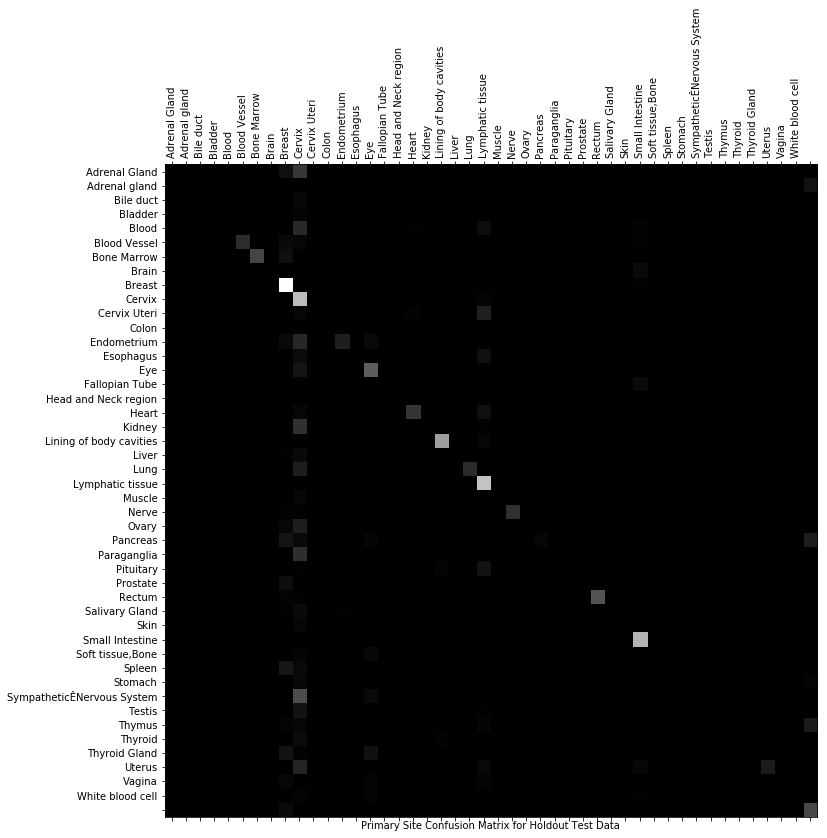

In [106]:
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    primary_site_test, np.array([np.argmax(p) for p in predictions]))

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.gray)
ax.set_xticklabels(primary_site_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(primary_site_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Primary Site Confusion Matrix for Holdout Test Data")
plt.show()

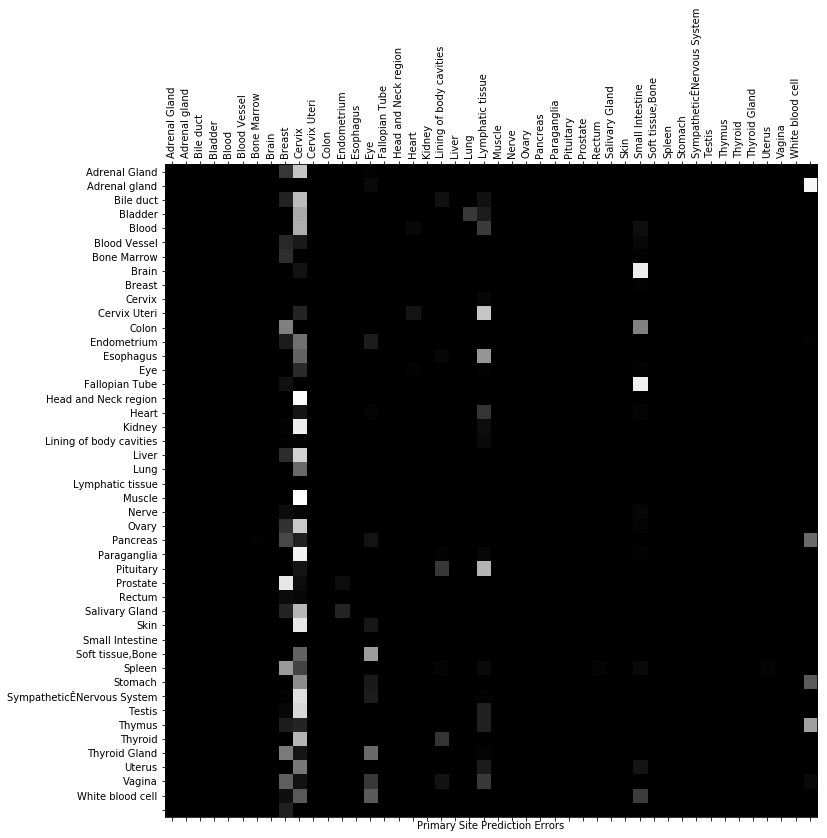

In [107]:
# Show only where there are errors
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.gray)
ax.set_xticklabels(primary_site_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(primary_site_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Primary Site Prediction Errors")
plt.show()

In [108]:
# Save the model for separate inference
with open("models/primary_site.params.json", "w") as f:
    f.write(json.dumps({
        "labels": primary_site_encoder.classes_.tolist(),
        "genes": all_gene_set_genes}))

with open("models/primary_site.model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("models/primary_site.weights.h5")